Домашнее задание "Методология ведения DS-проектов"

Возьмите задачу с винами (https://www.kaggle.com/rajyellow46/wine-quality) и решите ее, оформив в виде CrispDM-подхода.

# 1. Понимание бизнеса

## 1.1 Цель
Определить качество вина по его характеристикам.

## 1.2 Описание
Этот датасет содержит информацию о красном и белом вариантах португальского вина "Винью Верде".  Из-за проблем с конфиденциальностью и логистики доступны только физико-химические (исходные) и сенсорные (выходные) переменные (например, нет данных о сортах винограда, марке вина, цене продажи вина и т.д.).

Датасет можно рассматривать как задачу классификации или регрессии. Классы упорядочены и не сбалансированы (например, нормальных вин гораздо больше, чем отличных или плохих).

[Описание от Kaggle](https://www.kaggle.com/rajyellow46/wine-quality)

# 2. Data Understanding

## 2.1 Import Libraries

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import  Normalizer , scale
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

## 2.2 Вспомогательные функции

In [2]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    offset = (df[ var ].max() - df[ var ].min()) * 0.1
    facet.set( xlim=( df[ var ].min() - offset , df[ var ].max() + offset ) )
    facet.add_legend()

    
def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = wines.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

## 2.3 Загрузка данных

In [3]:
wines = pd.read_csv("winequalityN.csv")
print ('Dataset:' , wines.shape)

Dataset: (6497, 13)


## 2.4 Статистика и визуализации

In [4]:
wines.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [5]:
wines.tail()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5
6496,red,6.0,0.310,0.47,3.6,0.067,18.0,42.0,0.99549,3.39,0.66,11.0,6


**Описание переменных**

Входные переменные (на основе физико-химических тестов):

1 - тип вина (белое, красное)

2 - фиксированная кислотность

3 - летучая кислотность

4 - лимонная кислота

5 - остаточный сахар

6 - хлориды

7 - свободный диоксид серы

8 - общий диоксид серы

9 - плотность

10 - pH

11 - сульфаты

12 - процент алкоголя

Выходная переменная (на основе сенсорных данных):

13 - качество (оценка от 0 до 10)

[Больше информации на сайте Kaggle](https://www.kaggle.com/rajyellow46/wine-quality)

<AxesSubplot:>

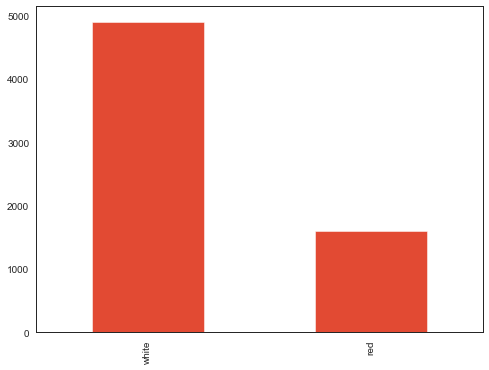

In [6]:
# посмотрим, какие есть варианты в поле type

wines.type.value_counts().plot.bar(x='lab', y='val')

<AxesSubplot:ylabel='Frequency'>

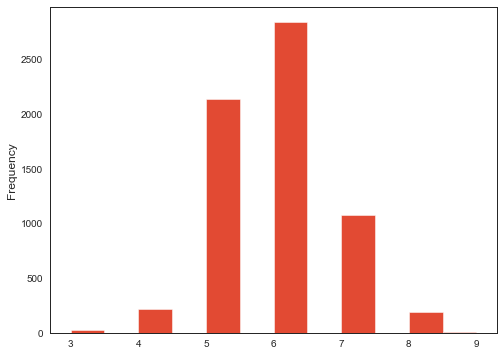

In [7]:
# посмотрим, какие есть варианты оценок и как они распределены

wines.quality.plot.hist(bins=12)

Классы не сбалансированы, нормальных вин гораздо больше, чем отличных или плохих.

### 2.4.1 Далее взглянем на некоторую ключевую информацию о переменных
Числовая переменная - это переменная со значениями в области целых или действительных чисел, в то время как категориальная переменная - это переменная, которая может принимать одно из ограниченного и обычно фиксированного числа возможных значений.

In [8]:
wines.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


### 2.4.2 Тепловая карта корреляции может дать нам понимание того, какие переменные важны

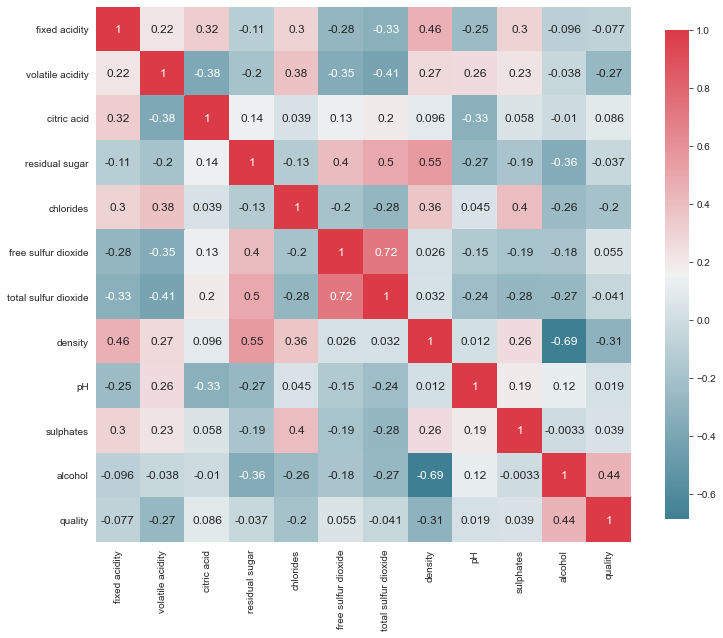

In [9]:
plot_correlation_map(wines)

Наиболее скоррелированны с качеством вина два показателя: процент алкоголя и плотность.

### 2.4.3 Подробнее рассмотрим корреляцию между процентом алкоголя и качеством вина

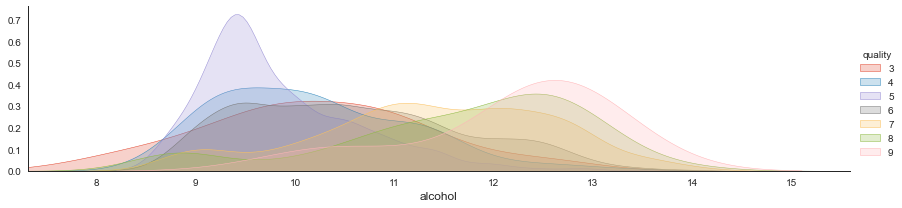

In [10]:
plot_distribution(wines, var = 'alcohol', target = 'quality')

По графику распределения уровня качества вина по уровню алкоголя видим, что распределения лучшего качества имеют прямую корреляцию с более высокими значениями алкоголя. Но все распределения перекрывают друг друга, значит однозначно определить качество вина по уровню алкоголя нельзя.

### 2.4.4 Подробнее рассмотрим корреляцию между плотностью и качеством вина

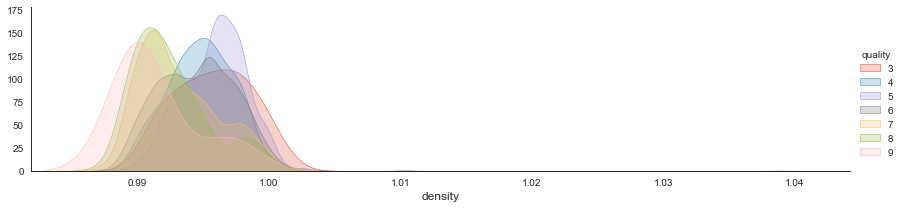

In [11]:
plot_distribution( wines , var = 'density' , target = 'quality')

На графике распределения уровня качества вина от плотности видим обратную корреляцию. Но распределения так же перекрывают друг друга, значит только по плотности качество вина не определить.

# 3. Data Preparation

## 3.1 Категориальные переменные должны быть преобразованы в числовые переменные

Переменная type - категориальные переменная. Некоторые из  алгоритмов могут обрабатывать только числовые значения, поэтому нам нужно создать новую (фиктивную) переменную для каждого уникального значения категориальных переменных.

In [12]:
type_w_r = pd.Series(np.where( wines['type'] == 'white', 1, 0), name = 'type')

## 3.2 Заполнить пропущенные значения в переменных
Большинство алгоритмов машинного обучения требуют, чтобы все переменные имели значения, чтобы использовать их для обучения модели. Самый простой метод - заполнить пропущенные значения средним по переменной для всех наблюдений в обучающем наборе.

In [13]:
wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


Видим пропуски в полях: fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, pH, sulphates. 

В качестве среднего возьмем среднее арифметическое.

In [14]:
def replace_nones(df, name):
    df[name] = df[name].fillna(df[name].mean())

for feature in ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'pH', 'sulphates']:
    replace_nones(wines, feature)

wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6497 non-null   float64
 2   volatile acidity      6497 non-null   float64
 3   citric acid           6497 non-null   float64
 4   residual sugar        6497 non-null   float64
 5   chlorides             6497 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


## 3.3 Feature Engineering &ndash; добавляем новые признаки

Если посмотреть на матрицу корреляций, то есть 2 пары наиболее скоррелированных признаков:

"free sulfur dioxide" и "total sulfur dioxide" со значением 0,72;

"density" и "alcohol" со значением -0,69.

Степень корреляции в каждой паре довольно высокая, однако, недостаточная для исключения одного из пары.

## 3.4 Сборка финальных датасетов для моделирования

### 3.4.1 Variable selection
Выбираем признаки для формирования итогового датасета.

In [15]:
feats = list(wines.columns)
feats.remove('type')
feats.remove('quality')

full_X = wines[feats]
full_X['type'] = type_w_r
full_X

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.450000,8.8,1
1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.490000,9.5,1
2,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.440000,10.1,1
3,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.400000,9.9,1
4,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.400000,9.9,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.580000,10.5,0
6493,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.531215,11.2,0
6494,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.750000,11.0,0
6495,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.710000,10.2,0


In [16]:
full_Y = wines['quality']

И нормализуем данные.

In [17]:
scaler = StandardScaler()
full_X_scaled = pd.DataFrame(scaler.fit_transform(full_X), index=full_X.index)

### 3.4.2 Создание датасетов

Отделяем данные для обучения и для проверки

In [18]:
tr_X, test_X, tr_y, test_y = train_test_split(full_X_scaled, full_Y, test_size = 0.3, random_state = 42)
train_X, valid_X, train_y, valid_y = train_test_split(tr_X, tr_y, test_size = 0.3, random_state = 42)

print(full_X.shape, train_X.shape, valid_X.shape, train_y.shape, valid_y.shape, test_X.shape)

(6497, 12) (3182, 12) (1365, 12) (3182,) (1365,) (1950, 12)


# 4. Моделирование
Теперь мы выберем модель, которую хотели бы попробовать. Используем обучающий набор данных для обучения модели и затем проверим ее с помощью тестового набора.

## 4.1 Выбор модели
В качестве классификатора выберем случайный лес RandomForestClassifier.

In [19]:
model = RandomForestClassifier(max_depth=10, n_estimators=30, random_state=42)

## 4.2 Обучение модели

In [20]:
model.fit( train_X , train_y )

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

# 5. Оценка
Теперь мы собираемся оценить модель

## 5.1 Модель
Мы можем оценить точность модели, используя набор для валидации, где мы знаем фактический результат. Этот набор данных не использовался для обучения, поэтому он абсолютно новый для модели.

Затем мы сравниваем точность с точностью при использовании модели на тренировочных данных. Если разница между ними значительна, это свидетельствует о переобучении. Мы стараемся избегать этого, потому что это означает, что модель не будет хорошо обобщаться на новые данные (будет работать плохо)

In [21]:
# Score the model
print (model.score(train_X, train_y), model.score(valid_X , valid_y))

0.8541797611565053 0.6117216117216118


## 5.2 Матрица ошибок

In [22]:
pred_y = model.predict(valid_X)
vals = list(set(valid_y.tolist() + list(pred_y)))

pd.DataFrame(confusion_matrix(valid_y, pred_y), columns=vals, index=vals)

,3,4,5,6,7,8,9
3,0,0,3,5,0,0,0
4,0,1,19,19,0,0,0
5,0,0,311,152,5,0,0
6,0,0,103,438,50,0,0
7,0,0,8,126,79,1,0
8,0,0,1,28,9,6,0
9,0,0,0,0,1,0,0


Качество модели получилось не очень хорошим, возможно из-за изначальной несбалансированности классов. Возможно улучшить качество модели, если разбивать датасет на обучающую и валидационную выборки не случайным образом, а так, чтобы в каждой равномерно присутствовали все классы.

# 6. Развертывание

Развертывание - представление результатов работы.

In [23]:
test_Y = model.predict( test_X )
test = wines.iloc[test_X.index]
test['quality_pred'] = test_Y
test.to_csv( 'wine_pred.csv' , index = False )
test.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_pred
3103,white,7.0,0.25,0.45,2.3,0.045,40.0,118.0,0.99064,3.16,0.48,11.9,7,7
1419,white,7.6,0.14,0.74,1.6,0.040,27.0,103.0,0.99160,3.07,0.40,10.8,7,6
4761,white,6.2,0.15,0.27,11.0,0.035,46.0,116.0,0.99602,3.12,0.38,9.1,6,6
4690,white,6.7,0.16,0.32,12.5,0.035,18.0,156.0,0.99666,2.88,0.36,9.0,6,6
4032,white,6.8,0.27,0.22,17.8,0.034,16.0,116.0,0.99890,3.07,0.53,9.2,5,5


In [24]:
test.tail()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_pred
4294,white,7.4,0.22,0.28,9.0,0.046,22.0,121.0,0.99468,3.10,0.55,10.8,5,6
3757,white,6.5,0.26,0.34,1.4,0.040,25.0,184.0,0.99216,3.29,0.46,10.7,5,5
5954,red,8.9,0.48,0.53,4.0,0.101,3.0,10.0,0.99586,3.21,0.59,12.1,7,7
4418,white,6.6,0.22,0.23,17.3,0.047,37.0,118.0,0.99906,3.08,0.46,8.8,6,6
6182,red,7.0,0.42,0.19,2.3,0.071,18.0,36.0,0.99476,3.39,0.56,10.9,5,6
